In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
#All data together

folder = Path(
    "C:/Users/tobia/OneDrive/Skrivebord/UNI/4. semester/Dataprojekt/2023 AAR vaskeri data"
)
files = list(folder.glob("PLC*.xlsx"))            # matches PLC, Product....xlsx etc.

dfs = []
monthly_data = {}

for f in files:
    df = pd.read_excel(f, header=2)                         # optionally: sheet_name="Sheet1"
    df["source_file"] = f.name                    # helpful traceability
    dfs.append(df)

    #dataframe for each individual month
    month_name = f.stem
    monthly_data[month_name] = df

all_data = pd.concat(dfs, ignore_index=True)
print(all_data.shape)
print(all_data.columns)
print(monthly_data.keys())

(248711, 7)
Index(['Produkt - Produkt', 'Kassationsårsag (ui)',
       'Stk. tøj per kassationsdato', 'Dage i cirkulation', 'Total antal vask',
       'Unik Kode (ui)', 'source_file'],
      dtype='object')
dict_keys(['PLC, Product detaljeret, Aarhus, Apr. 2023', 'PLC, Product detaljeret, Aarhus, Aug. 2023', 'PLC, Product detaljeret, Aarhus, Dec. 2023', 'PLC, Product detaljeret, Aarhus, Feb. 2023', 'PLC, Product detaljeret, Aarhus, Jan. 2023', 'PLC, Product detaljeret, Aarhus, Jul. 2023', 'PLC, Product detaljeret, Aarhus, Jun. 2023', 'PLC, Product detaljeret, Aarhus, Maj, 2023', 'PLC, Product detaljeret, Aarhus, Mar. 2023', 'PLC, Product detaljeret, Aarhus, Nov. 2023', 'PLC, Product detaljeret, Aarhus, Okt. 2023', 'PLC, Product detaljeret, Aarhus, Sep. 2023'])


In [3]:
def find_kategori(navn):
    if not isinstance(navn, str): return "Ukendt"
    navn_ren = navn.lower().replace(',', '').replace('.', '')
    
    # 1. SPECIALBEKLÆDNING (Skal fanges først!) 
    if 'term' in navn_ren: return 'Termotøj'
    if 'kedeldr' in navn_ren: return 'Kedeldragt'
    if 'overall' in navn_ren: return 'Overalls'
    
    # Flyttet op: Hvis det er kokketøj (kokkejakke/kokkebuks, osv.) fanges det her
    if 'kok' in navn_ren: return 'Kokketøj' 
    
    # 2. UNDERDELE 
    if 'underbuk' in navn_ren: return 'Underbukser'
    if any(x in navn_ren for x in ['ben', 'buks', 'jeans', 'unisexben']): return 'Bukser'
    if 'shorts' in navn_ren: return 'Shorts'
    
    # 3. OVERDELE
    if 'cardigan' in navn_ren: return 'Cardigan'
    if 'sweat' in navn_ren: return 'Sweatshirt'

    if any(x in navn_ren for x in ['t-shirt', 'tshirt']): return 'T-shirt' 

    if 'polo' in navn_ren: return 'Polo'
    if 'hætte' in navn_ren: return 'Hættetrøje'
    if 'skj' in navn_ren: return 'Skjorte'
    if 'bussero' in navn_ren: return 'Busseronne'
    if 'tunika' in navn_ren: return 'Tunika'
    if 'kit' in navn_ren: return 'Kittel'
    if 'vest' in navn_ren: return 'Vest'
    
   
    # Denne linje fanger kun jakker, der IKKE eksempelvis er kokkejakker eller termojakker. 
    if any(x in navn_ren for x in ['jak', 'jk']): return 'Jakke'
    
    if 'fleece' in navn_ren: return 'Fleece'
    if 'kasket' in navn_ren: return 'Kasket'
    
    # 4. KØKKEN & TILBEHØR
    if 'forklæde' in navn_ren or 'smæk' in navn_ren: return 'Forklæde'

    
    # Opsamling
    parts = navn_ren.split()
    if len(parts) > 1:
        return "Andet (" + parts[1].title() + ")"
    return "Andet"

In [4]:
# Antal kategorier i plottet
N = 10 

# Muligheder: 'Dage i cirkulation'  ELLER  'Total antal vask'
y_akse_navn = 'Dage i cirkulation'

# Forberedelse af data - sørg for at have indlæst dataen inden
if 'Kategori' not in all_data.columns:
    all_data['Kategori'] = all_data['Produkt - Produkt'].apply(find_kategori)

# Sikre at kolonnerne er tal
cols_to_numeric = ['Dage i cirkulation', 'Total antal vask']
for col in cols_to_numeric:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

# Find de N mest populære kategorier
top_kategorier = all_data['Kategori'].value_counts().head(N).index
df_plot = all_data[all_data['Kategori'].isin(top_kategorier)]

# Fjern ekstreme outliers (skal måske tweakes lidt)
if y_akse_navn == 'Dage i cirkulation':
    grænse = 4000 # Fjern alt over ca 11 år
elif y_akse_navn == 'Total antal vask':
    grænse = 300  # Fjern alt over 300 vaske
    
df_plot = df_plot[df_plot[y_akse_navn] < grænse]

df_plot

,Produkt - Produkt,Kassationsårsag (ui),Stk. tøj per kassationsdato,Dage i cirkulation,Total antal vask,Unik Kode (ui),source_file,Kategori
213,03982 Jakke hyg kina 2 indv lom,Udgået Model,1,3987,232,00D007E812A5,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx",Jakke
214,03666 Skjorte Kblå U/Lom M/Trykkna,Misligholdt med restværdi,1,3974,75,00D007AEBA0F,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx",Skjorte
215,01589 T-shirt unisex mblå k/æ,Misligholdt med restværdi,1,3964,76,00D006CEFA6A,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx",T-shirt
216,03666 Skjorte Kblå U/Lom M/Trykkna,Alm.slid uden restværdi,1,3962,81,00D007B29BA2,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx",Skjorte
218,03982 Jakke hyg kina 2 indv lom,BTS fejl uden restværdi,1,3957,73,00D007CA7DD3,"PLC, Product detaljeret, Aarhus, Apr. 2023.xlsx",Jakke
...,...,...,...,...,...,...,...,...
248706,28722 T-shirt ACC rød/ant,Udgået Model,1,0,0,30155C97D461A6C000D54984,"PLC, Product detaljeret, Aarhus, Sep. 2023.xlsx",T-shirt
248707,28722 T-shirt ACC rød/ant,Udgået Model,1,0,0,30155C97D461A6C001152FCE,"PLC, Product detaljeret, Aarhus, Sep. 2023.xlsx",T-shirt
248708,28793 Benkl M/Lom Grå Low Risk,Misligeholdt pga blæk,1,0,0,00D00AE3840A,"PLC, Product detaljeret, Aarhus, Sep. 2023.xlsx",Bukser
248709,28793 Benkl M/Lom Grå Low Risk,Misligholdt med restværdi,1,0,0,00D00AE38B9E,"PLC, Product detaljeret, Aarhus, Sep. 2023.xlsx",Bukser


# Buler omkring 1600-2400 dage i cirkulation

I violinplotsne er der ved kategorierne t-shirt, skjorte, fleece og vest en bule med mange kassationer i perioden 1600-2400 dage i cirkulation.
Det følgende er en procentvis fordeling af kassationsårsag for de kategorier i den periode.

## t-shirt bule

In [5]:
#t-shirt bule omkring 2000 dage i cirkulation
tshirts_subdata = df_plot.loc[
    (df_plot['Kategori'] == 'T-shirt') &
    (df_plot['Dage i cirkulation'].between(1600, 2400))
]

#procentvis fordeling
tshirts_subdata['Kassationsårsag (ui)'].value_counts(normalize = True).mul(100)

Kassationsårsag (ui)
Alm.slid uden restværdi                   37.564541
Misligholdt med restværdi                 20.438544
Bortkommet med restværdi                  16.274391
Kass. af RETUR,MINIMU,afmeld              10.172333
BTS fejl uden restværdi                    8.368538
Udgået Model                               5.190103
Misligeholdt pga blæk                      1.461812
Ødelagt af lommefyld uden restværdi        0.254811
Beholdningsnedskrivning uden restværdi     0.254811
Ødelagt af lommefyld med restværdi         0.013411
Produktfejl                                0.006706
Name: proportion, dtype: float64

Der ved første glans ikke nogle speciel kassationsårsag der er til grund for bulen, men det kræver dybere analyse at sige noget konkret.

## Skjorte bule

In [6]:
#skjorte bule omkring 1600-2400 dage i cirkulation
skjorte_subdata = df_plot.loc[
    (df_plot['Kategori'] == 'Skjorte') &
    (df_plot['Dage i cirkulation'].between(1600, 2400))
]

#procentvis fordeling
skjorte_subdata['Kassationsårsag (ui)'].value_counts(normalize = True).mul(100)

Kassationsårsag (ui)
Alm.slid uden restværdi                   39.207780
Bortkommet med restværdi                  21.703036
Udgået Model                              17.196395
BTS fejl uden restværdi                   11.408918
Misligholdt med restværdi                  4.886148
Kass. af RETUR,MINIMU,afmeld               3.629032
Ødelagt af lommefyld uden restværdi        1.328273
Misligeholdt pga blæk                      0.498102
Ødelagt af lommefyld med restværdi         0.071157
Beholdningsnedskrivning uden restværdi     0.047438
Produktfejl                                0.023719
Name: proportion, dtype: float64

En høj procentværdi for udgået model kan forklare bulen. Kræver dog dybere analyse.

## Fleece bule

In [7]:
#fleece bule omkring 1600-2400 dage i cirkulation
fleece_subdata = df_plot.loc[
    (df_plot['Kategori'] == 'Fleece') &
    (df_plot['Dage i cirkulation'].between(1600, 2400))
]

#procentvis fordeling
fleece_subdata['Kassationsårsag (ui)'].value_counts(normalize = True).mul(100)

Kassationsårsag (ui)
Alm.slid uden restværdi                46.148148
Bortkommet med restværdi               37.111111
Kass. af RETUR,MINIMU,afmeld            5.629630
Udgået Model                            5.259259
BTS fejl uden restværdi                 5.185185
Ødelagt af lommefyld uden restværdi     0.444444
Misligholdt med restværdi               0.148148
Misligeholdt pga blæk                   0.074074
Name: proportion, dtype: float64

## vest bulen

In [10]:
#Vest bule omkring 1600-2400 dage i cirkulation
vest_subdata = df_plot.loc[
    (df_plot['Kategori'] == 'Vest') &
    (df_plot['Dage i cirkulation'].between(1600, 2400))
]

#procentvis fordeling
vest_subdata['Kassationsårsag (ui)'].value_counts(normalize = True).mul(100)

Kassationsårsag (ui)
Alm.slid uden restværdi                69.177609
Bortkommet med restværdi               25.224603
Udgået Model                            1.727713
BTS fejl uden restværdi                 1.658604
Misligholdt med restværdi               1.243953
Kass. af RETUR,MINIMU,afmeld            0.898411
Ødelagt af lommefyld uden restværdi     0.069109
Name: proportion, dtype: float64

## sammenligning af violin plots i perioden og total dataset

C:\Users\tobia\AppData\Local\Temp\ipykernel_19524\3583820632.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=alle_tshirts_pct,
C:\Users\tobia\AppData\Local\Temp\ipykernel_19524\3583820632.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= sub_pct,


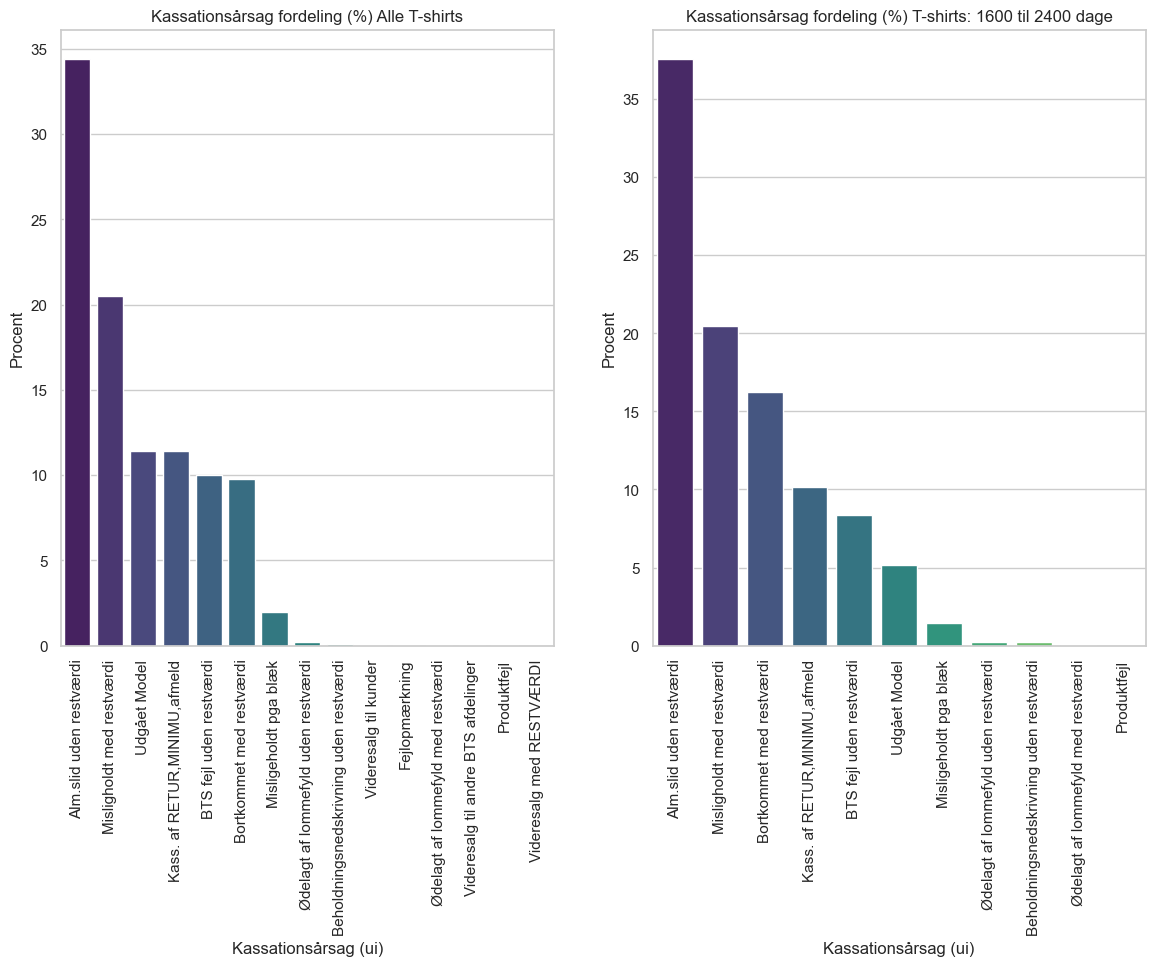

In [11]:
# Beregn procenter
alle_tshirts_pct = (
    df_plot.loc[df_plot['Kategori'] == 'T-shirt']['Kassationsårsag (ui)']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
)
alle_tshirts_pct.columns = ['Kassationsårsag (ui)', 'Procent']

sub_pct = (
    tshirts_subdata['Kassationsårsag (ui)']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
)
sub_pct.columns = ['Kassationsårsag (ui)', 'Procent']

#plotting
fig, ax = plt.subplots(1,2, figsize =(14,8))
fig.subplots_adjust(wspace=0.2)

sns.set_theme(style='whitegrid')
sns.barplot(data=alle_tshirts_pct,    
               x='Kassationsårsag (ui)',
               y = 'Procent',  
               palette="viridis", 
               ax= ax[0]
               )
ax[0].set_title("Kassationsårsag fordeling (%) Alle T-shirts")
ax[0].set_ylabel("Procent")

sns.barplot(data= sub_pct,
               x = 'Kassationsårsag (ui)',
               y = 'Procent',
               palette='viridis',
               ax = ax[1])
ax[1].set_title("Kassationsårsag fordeling (%) T-shirts: 1600 til 2400 dage")
ax[1].set_ylabel("Procent")

ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)